In [14]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle

%matplotlib inline

In [15]:
folder_Pk = '/global/cscratch1/sd/jialiu/CAMELS/Pk/' ### original, unorganized Pk
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

In [16]:
### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

In [60]:
######### get k, which is the same for all sims and all redshift, I think..
k=np.loadtxt(home+'CAMELS/Pk/IllustrisTNG/LH_0/Pk_m_z=0.00.txt').T[0]
np.save(home+'Pk/IllustrisTNG_k_m_z=0.00.npy', k)

kmax=30
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')
Nk=sum(k<kmax)
kcut=k[:Nk]
print (Nk)
labels=[r'$\Omega_m$', r'$\sigma_8$', '$log_{10}(A_1)$', '$log_{10}(A_2)$', '$log_{10}(A_3)$', '$log_{10}(A_4)$']

### organize the files
def organize_Pk (iz, isim, iPk='Pk_m'):
        
    sim_name = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=(0), dtype='U')
    sim_params = np.loadtxt(home+'params/CosmoAstroSeed_%s.txt'%(isim), usecols=range(1,7))
    #### change all the baryon parameters to log
    sim_params = concatenate([sim_params[:,:2], log10(sim_params[:,2:])],axis=1)
    
    Pk_arr = array([np.loadtxt(folder_Pk+'%s/%s/%s_z=%.2f.txt'%(isim, iLH, iPk, iz))[:Nk] for iLH in sim_name])
    Pk_DM_arr = array([np.loadtxt(folder_Pk+'%s_DM/%s/%s_z=%.2f.txt'%(isim, iLH, iPk, iz))[:Nk] for iLH in sim_name])
    
    for iset in ('LH', '1P', 'CV'):
        idx = where(np.char.find(sim_name, iset)!=-1)
        ifn=home+'Pk/%s_%s_%s_z=%.2f.npy'%(isim, iPk, iset, iz)
        ifn_DM=home+'Pk/%s_%s_%s_z=%.2f_DM.npy'%(isim, iPk, iset, iz)
        data_arr = concatenate([sim_params[idx], Pk_arr[idx][:,:,1]],axis=1) ## include params and Pk
        data_DM_arr = concatenate([sim_params[idx], Pk_DM_arr[idx][:,:,1]],axis=1) ## include params and Pk
        save(ifn, data_arr)
        save(ifn_DM, data_DM_arr)
        
        print (data_arr.shape)

118


In [27]:
######## all CAMELS sims
sim_arr = ['IllustrisTNG',  'SIMBA'] #'Astrid'

######### the redshift we're interested in
zarr=[0.00, 1.05, 2.00, 3.00] #, 0.05, 0.10, 0.15] #

####### organize the files, take long #########
# for isim in sim_arr:
#     for iz in zarr:
#         print (isim, iz)
#         organize_Pk (iz, isim, iPk='Pk_m')

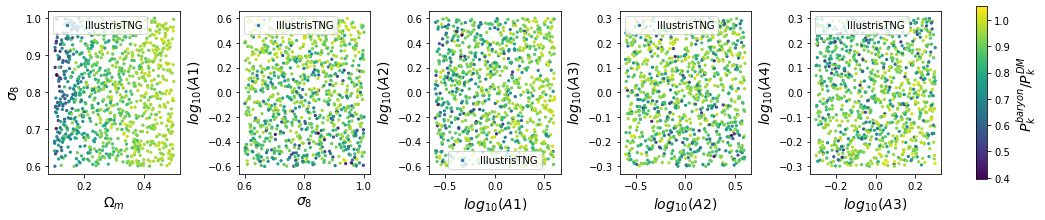

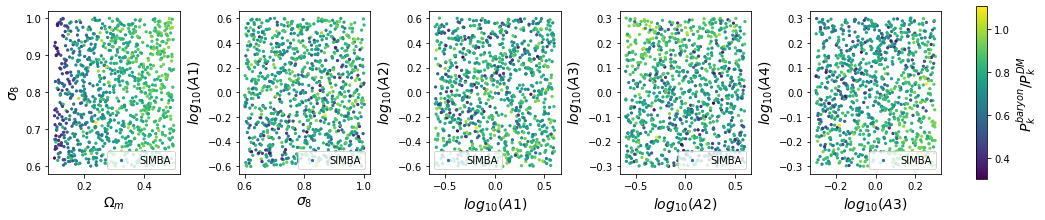

In [72]:
########### validate the tests
iPk = 'Pk_m'
iz = 0
iset = 'LH'
isim = 'IllustrisTNG'

for isim in sim_arr:
    ifn = home+'Pk/%s_%s_%s_z=%.2f.npy'%(isim, iPk, iset, iz)
    ifn_DM=home+'Pk/%s_%s_%s_z=%.2f_DM.npy'%(isim, iPk, iset, iz)
    Pk_arr = np.load(ifn)
    Pk_DM_arr = np.load(ifn_DM)
    Pk_arr.shape

    params = Pk_arr[:, :6]
    r = Pk_arr[:, 6:]/Pk_DM_arr[:, 6:]
    rprox = mean(r[:, 5:20],axis=1)
    # params.shape, r.shape, rprox.shape

    f, ax=subplots(1,5, figsize=(16,3))

    for i in range(5):
        im=ax[i].scatter(params.T[i], params.T[i+1], c=rprox, label=isim, s=5)
        ax[i].set_xlabel(labels[i], fontsize=14)
        ax[i].set_ylabel(labels[i+1],fontsize=14)   
        ax[i].legend()
    cbar_ax = f.add_axes([0.93, 0.1, 0.01, 0.8])
    f.colorbar(im, cax=cbar_ax)
    f.subplots_adjust(wspace=0.45)
    cbar_ax.set_ylabel(r'$P_k^{baryon}/P_k^{DM}$',fontsize=14)
    show()